In [1]:
import pandas as pd
import wandb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from tabulate import tabulate

api = wandb.Api()

In [ ]:
project = "sh_frame_stack"
runs = api.runs(f"amar-research/{project}")
cycles = 5
methods = ['local', 'uniform', 'prioritized']
exclude = ["best"]


summary_list, config_list, name_list = [], [], []
method_dict = {}
for method in methods:
    method_dict[method] = np.zeros((6,5))

for cycle in range(cycles+1):
    for method in methods:
        for run in runs:
            for exclusion in exclude:
                if exclusion in run.name:
                    continue
                if run.summary.get('_runtime') < 20.0:
                    continue
                
                if run.name == f"EGO{cycle}_eval_{method}":
                    print(run.name)
                    for npc in range(5):
                        method_dict[method][cycle][npc] = run.summary[f"checkpoint_summary/DQNPolicy{npc}/num_crashes"]

def print_method_tables(method_dict, floatfmt=".2f"):
    for method, mat in method_dict.items():
        # Build headers: "", V0..V{n-1}
        headers = [""] + [f"V{j}" for j in range(mat.shape[1])]
        # Build rows with E0..E{m-1} labels
        rows = [[f"E{i}", *mat[i]] for i in range(mat.shape[0])]
        print(method.upper())
        print(tabulate(rows, headers=headers, tablefmt="github", floatfmt=floatfmt))
        print()  # blank line between methods

def print_method_tables_with_means(method_dict, floatfmt=".2f", use_nanmean=False):
    mean_fn = np.nanmean if use_nanmean else np.mean

    for method, mat in method_dict.items():
        # Compute means
        row_means = mean_fn(mat, axis=1)
        col_means = mean_fn(mat, axis=0)
        overall_mean = mean_fn(mat)

        # Headers: "", V0..V{n-1}, Mean
        headers = [""] + [f"V{j}" for j in range(mat.shape[1])] + ["Mean"]

        # Rows E0..E{m-1} with row means
        rows = [[f"E{i}", *mat[i], row_means[i]] for i in range(mat.shape[0])]

        # Bottom mean row
        mean_row = ["Mean", *col_means, overall_mean]
        rows.append(mean_row)

        print(method.upper())
        print(tabulate(rows, headers=headers, tablefmt="github", floatfmt=floatfmt))
        print()  # spacing

print_method_tables_with_means(method_dict)


runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

EGO0_eval_local
EGO0_eval_uniform
EGO0_eval_prioritized
EGO1_eval_local
EGO1_eval_uniform
EGO1_eval_prioritized
EGO2_eval_local
EGO2_eval_uniform
EGO2_eval_prioritized
EGO3_eval_local
EGO3_eval_uniform
EGO3_eval_prioritized
EGO4_eval_local
EGO4_eval_uniform
EGO4_eval_prioritized
EGO5_eval_local
EGO5_eval_uniform
EGO5_eval_prioritized
LOCAL
|      |   V0 |   V1 |   V2 |   V3 |   V4 |   Mean |
|------|------|------|------|------|------|--------|
| E0   | 0.99 | 0.93 | 0.96 | 0.88 | 0.98 |   0.95 |
| E1   | 0.40 | 0.98 | 0.81 | 0.96 | 0.97 |   0.82 |
| E2   | 0.62 | 0.73 | 0.98 | 0.92 | 0.90 |   0.83 |
| E3   | 0.46 | 0.62 | 0.75 | 0.96 | 0.92 |   0.74 |
| E4   | 0.68 | 0.79 | 0.81 | 0.66 | 1.00 |   0.79 |
| E5   | 0.52 | 0.73 | 0.77 | 0.78 | 0.67 |   0.69 |
| Mean | 0.61 | 0.79 | 0.85 | 0.86 | 0.91 |   0.80 |

UNIFORM
|      |   V0 |   V1 |   V2 |   V3 |   V4 |   Mean |
|------|------|------|------|------|------|--------|
| E0   | 1.00 | 1.00 | 1.00 | 1.00 | 0.99 |   1.00 |
| E1   | 0.70

In [3]:
import numpy as np

def method_tables_to_latex(
    method_dict: dict[str, np.ndarray],
    methods: list[str],
    var_prefix: str = "V_",
    row_prefix: str = "E_",
    start_index: int = 1,
    floatfmt: str = ".2f",
    use_nanmean: bool = True,
    tablefmt_bars: bool = True,
    scriptsize_subheaders: bool = True,
) -> str:
    """Generate LaTeX tabular with method_dict — no colors, no arrows, just numbers."""
    if not methods:
        raise ValueError("methods list must be non-empty")

    first_key = next(iter(method_dict))
    M, N = method_dict[first_key].shape
    for m in methods:
        if m not in method_dict:
            raise KeyError(f"method '{m}' missing")
        if method_dict[m].shape != (M, N):
            raise ValueError(f"matrix for '{m}' must be {(M, N)}")

    mean_fn = np.nanmean if use_nanmean else np.mean

    def fmt(x): return f"{x:{floatfmt}}"
    def escape_tex(s: str): return s.replace("_", r"\_")
    def maybe_script(s: str): return f"\\scriptsize{{{s}}}" if scriptsize_subheaders else s

    # Compute per-row and per-column means
    row_means = {m: mean_fn(method_dict[m], axis=1) for m in methods}
    bottom_cols = [{m: mean_fn(method_dict[m][:, j]) for m in methods} for j in range(N)]
    bottom_overall = {m: mean_fn(method_dict[m]) for m in methods}

    # Column spec (with vertical bars)
    group_count = N + 1
    group_spec = "|".join(["c" * len(methods)] * group_count)
    colspec = f"|l|{group_spec}|"
    if not tablefmt_bars:
        colspec = "l" + "c" * (group_count * len(methods))

    # Header rows
    group_titles = [
        f"\\multicolumn{{{len(methods)}}}{{c|}}{{{escape_tex(var_prefix)}{j + start_index}}}"
        for j in range(N)
    ] + [f"\\multicolumn{{{len(methods)}}}{{c}}{{Mean}}"]
    header_row1 = "    & " + " & ".join(group_titles) + r" \\ \hline"

    subheads = []
    for _ in range(N + 1):
        subheads.extend([maybe_script(escape_tex(m.capitalize())) for m in methods])
    header_row2 = "    & " + " & ".join(subheads) + r"  \\ \hline"

    # Body rows
    body_lines = []
    for i in range(M):
        cells = []
        for j in range(N):
            for m in methods:
                val = method_dict[m][i, j]
                cells.append(fmt(val))
        for m in methods:
            cells.append(fmt(row_means[m][i]))
        body_lines.append(f"    {row_prefix}{i} & " + " & ".join(cells) + r" \\ ")

    # Bottom mean row
    bottom_cells = []
    for j in range(N):
        for m in methods:
            bottom_cells.append(fmt(bottom_cols[j][m]))
    for m in methods:
        bottom_cells.append(fmt(bottom_overall[m]))
    bottom_line = "    Mean & " + " & ".join(bottom_cells) + r" \\ \hline"

    # Assemble final LaTeX
    lines = [
        f"\\begin{{tabular}}{{{colspec}}}",
        "    \\hline",
        header_row1,
        header_row2,
        *body_lines,
        bottom_line,
        "\\end{tabular}",
    ]
    return "\n".join(lines)

In [7]:
label_fontsize = 12
plt.rcParams.update({'font.size': label_fontsize})
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["mathtext.fontset"] = "dejavuserif"
ticks_font = "serif"

def plot_mean_across_egos(method_dict, methods, use_nanmean=True, start_v_index=1, save = None):
    """
    For each method, compute mean over NPC versions (columns) for every ego row,
    and plot all methods together on one figure.
    """
    mean_fn = np.nanmean if use_nanmean else np.mean

    # Infer shape from first matrix
    first_key = methods[0]
    M, N = method_dict[first_key].shape

    x = np.arange(M)  # E0..E{M-1}
    plt.figure()
    for m in methods:
        mat = method_dict[m]
        y = mean_fn(mat, axis=1)  # mean across columns (NPCs) per ego row
        plt.plot(x, y, marker='o', label=m.capitalize())
    plt.xlabel("Ego Version")
    plt.ylabel("Crash Rate")
    #plt.title("Mean Crash Rate vs. Ego Version (per method)")
    plt.legend(loc='lower right')
    plt.ylim(0,1)
    plt.grid(True)
    plt.tight_layout()
    for label in plt.gca().get_xticklabels():
        label.set_fontproperties(ticks_font)
    
    for label in plt.gca().get_yticklabels():
        label.set_fontproperties(ticks_font)

    if save:
        plt.savefig(save)


def plot_mean_across_npcs(method_dict, methods, use_nanmean=True, start_v_index=1, save = None):
    """
    For each method, compute mean over ego rows for every NPC column,
    and plot all methods together on one figure.
    """
    mean_fn = np.nanmean if use_nanmean else np.mean

    first_key = methods[0]
    M, N = method_dict[first_key].shape

    x = np.arange(start_v_index, start_v_index + N)  # V_1..V_N (or V_0.. if you prefer)
    plt.figure()
    for m in methods:
        mat = method_dict[m]
        y = mean_fn(mat, axis=0)  # mean across rows (egos) per NPC column
        plt.plot(x, y, marker='o', label=m.capitalize())
    plt.xlabel("NPC Version")
    plt.ylabel("Crash Rate")
    #plt.title("Mean Crash Rate vs. NPC Version (per method)")
    plt.legend(loc='lower right')    
    plt.ylim(0,1)
    plt.xticks(np.arange(start_v_index, start_v_index + N))
    plt.grid(True)
    plt.tight_layout()

    for label in plt.gca().get_xticklabels():
        label.set_fontproperties(ticks_font)
    
    for label in plt.gca().get_yticklabels():
        label.set_fontproperties(ticks_font)


    if save:
        plt.savefig(save)

In [5]:
latex_code = method_tables_to_latex(
    method_dict,
    methods=['local', 'uniform', 'prioritized'],
    var_prefix="V_",
    row_prefix="E_",
    start_index=1,
    floatfmt=".2f",
    use_nanmean=True
)
print(latex_code)

\begin{tabular}{|l|ccc|ccc|ccc|ccc|ccc|ccc|}
    \hline
    & \multicolumn{3}{c|}{V\_1} & \multicolumn{3}{c|}{V\_2} & \multicolumn{3}{c|}{V\_3} & \multicolumn{3}{c|}{V\_4} & \multicolumn{3}{c|}{V\_5} & \multicolumn{3}{c}{Mean} \\ \hline
    & \scriptsize{Local} & \scriptsize{Uniform} & \scriptsize{Prioritized} & \scriptsize{Local} & \scriptsize{Uniform} & \scriptsize{Prioritized} & \scriptsize{Local} & \scriptsize{Uniform} & \scriptsize{Prioritized} & \scriptsize{Local} & \scriptsize{Uniform} & \scriptsize{Prioritized} & \scriptsize{Local} & \scriptsize{Uniform} & \scriptsize{Prioritized} & \scriptsize{Local} & \scriptsize{Uniform} & \scriptsize{Prioritized}  \\ \hline
    E_0 & 0.99 & 1.00 & 0.98 & 0.93 & 1.00 & 1.00 & 0.96 & 1.00 & 0.97 & 0.88 & 1.00 & 0.93 & 0.98 & 0.99 & 0.99 & 0.95 & 1.00 & 0.97 \\ 
    E_1 & 0.40 & 0.70 & 0.61 & 0.98 & 0.98 & 0.98 & 0.81 & 0.96 & 0.87 & 0.96 & 0.86 & 0.61 & 0.97 & 0.98 & 0.59 & 0.82 & 0.90 & 0.73 \\ 
    E_2 & 0.62 & 0.61 & 0.54 & 0.73 & 0.99 & 0

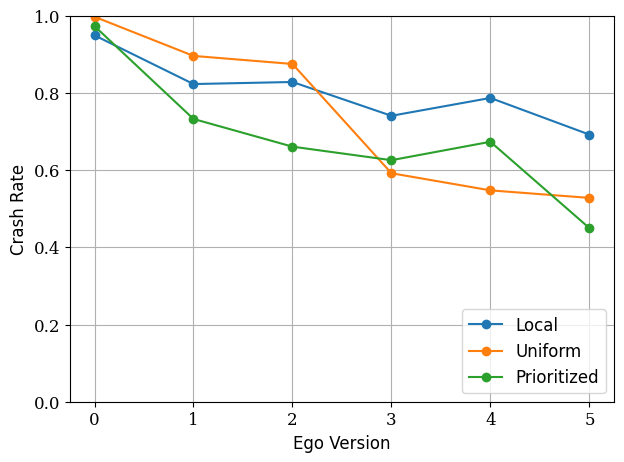

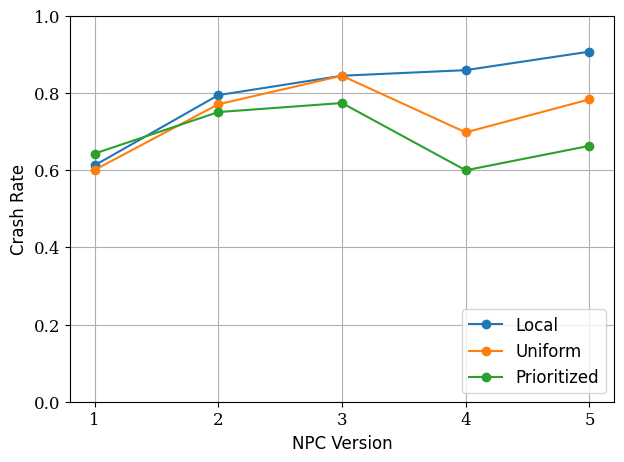

In [8]:
methods = ['local', 'uniform', 'prioritized']
ego_save_path = os.path.join("/u/ark8su/safetyh/figures", f"{project}_ego_mean_crash_rates.pdf")
npc_save_path = os.path.join("/u/ark8su/safetyh/figures", f"{project}_npc_mean_crash_rates.pdf")

# 1) Mean across NPCs vs. Ego version (rows)
plot_mean_across_egos(method_dict, methods, save = ego_save_path)

# 2) Mean across Egos vs. NPC version (cols)
plot_mean_across_npcs(method_dict, methods, start_v_index=1, save = npc_save_path)

plt.show()  # if running in a script